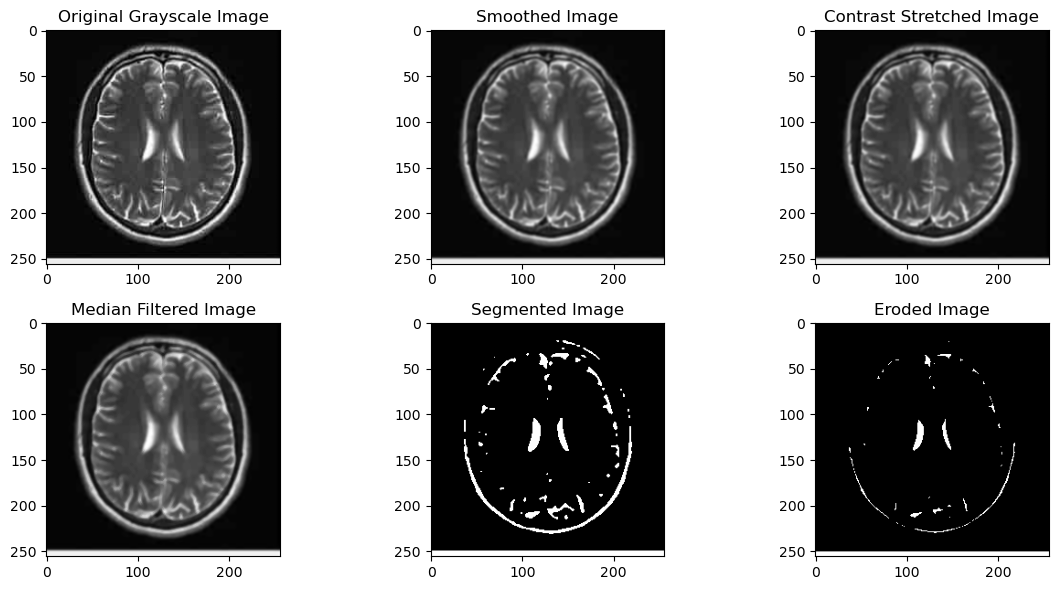

No tumor is present.


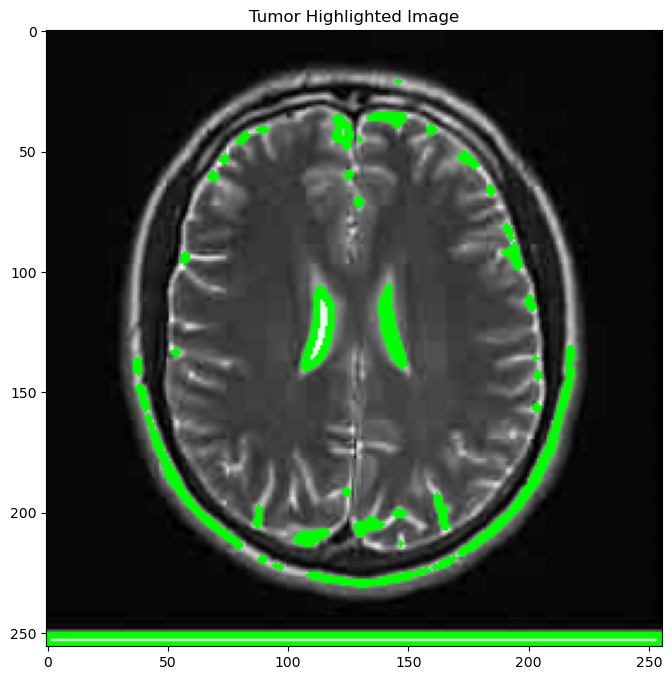

In [2]:
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io
import cv2
import numpy as np
from scipy import ndimage
from skimage import img_as_ubyte, img_as_uint
import matplotlib.pyplot as plt

# Create an upload widget
upload_button = widgets.FileUpload(
    description="Upload Image",
    accept=".jpg, .jpeg, .png",  # Define allowed file extensions
    multiple=False  # Set to True if you want to allow multiple file uploads
)

# Display the upload widget
display(upload_button)

# Function to preprocess and detect tumors
def preprocess_and_detect_tumor(image_data):
    img = Image.open(io.BytesIO(image_data))
    
    
    # Convert to numpy array in RGB format
    img_array = np.array(img)
    
    # Ensure consistent image size
    target_size = (256, 256)  # Adjust the target size as needed
    img_array = cv2.resize(img_array, target_size)
    
    # Convert to grayscale
    gray_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    
    # Smoothing the Image (Apply Gaussian Blur)
    smoothed_image = cv2.GaussianBlur(gray_array, (5, 5), 0)
    
    # Contrast Stretching
    min_intensity = np.min(smoothed_image)
    max_intensity = np.max(smoothed_image)
    contrast_stretched_image = ((smoothed_image - min_intensity) / (max_intensity - min_intensity) * 255).astype(np.uint8)
    
    
    # Median Filtering for Noise Reduction
    median_filtered_image = ndimage.median_filter(contrast_stretched_image, size=3)
    
    # Segmentation (Simple Thresholding)
    threshold_value = 150  # Adjust the threshold value as needed
    segmented_image = (median_filtered_image > threshold_value).astype(np.uint8)
    
    # Erosion (Morphological Operation)
    erosion_element = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))  # Adjust the structuring element as needed
    eroded_image = cv2.erode(segmented_image, erosion_element, iterations=1)
    
    # Find contours to detect the tumor
    contours, _ = cv2.findContours(eroded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Highlight Tumor on Original Image
    tumor_highlighted_image = img_as_ubyte(np.copy(img_array))
    cv2.drawContours(tumor_highlighted_image, contours, -1, (0, 255, 0), 2)  # Highlight contours in green
    
    return gray_array, smoothed_image, contrast_stretched_image, median_filtered_image, segmented_image, eroded_image, tumor_highlighted_image, contours

# Handle file upload and preprocessing
def handle_upload(change):
    clear_output()
    uploaded_image = upload_button.value  # Get the uploaded file

    # Check if any file was uploaded
    if uploaded_image:
        # Extract image data
        image_data = uploaded_image[0]["content"]

        # Apply preprocessing and tumor detection
        gray_img, smoothed_img, contrast_stretched_img, median_filtered_img, segmented_img, eroded_img, tumor_highlighted_img, contours = preprocess_and_detect_tumor(image_data)

        # Display the original grayscale image
        plt.figure(figsize=(12, 6))
        plt.subplot(2, 3, 1)
        plt.imshow(gray_img, cmap='gray')
        plt.title('Original Grayscale Image')

        # Display the smoothed image
        plt.subplot(2, 3, 2)
        plt.imshow(smoothed_img, cmap='gray')
        plt.title('Smoothed Image')

        # Display the contrast-stretched image
        plt.subplot(2, 3, 3)
        plt.imshow(contrast_stretched_img, cmap='gray')
        plt.title('Contrast Stretched Image')

        # Display the median-filtered image
        plt.subplot(2, 3, 4)
        plt.imshow(median_filtered_img, cmap='gray')
        plt.title('Median Filtered Image')

        # Display the segmented image
        plt.subplot(2, 3, 5)
        plt.imshow(segmented_img, cmap='gray')
        plt.title('Segmented Image')

        # Display the eroded image
        plt.subplot(2, 3, 6)
        plt.imshow(eroded_img, cmap='gray')
        plt.title('Eroded Image')

        plt.tight_layout()
        plt.show()

        # Display the final image with tumor highlighted on the original image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(tumor_highlighted_img, cv2.COLOR_BGR2RGB))
        plt.title('Tumor Highlighted Image')

        # Display tumor detection result
        if len(contours) == 1:
            print("Tumor is present. Detected 1 tumor region.")
        else:
            print("No tumor is present.")
    else:
        print("No image uploaded.")

# Attach the handle_upload function to the widget's observe method
upload_button.observe(handle_upload, names="value")
